# Reforming the basic functions to be non-generic

## Reforming the `draw_full_contour` function to simpler functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSCm
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy import integrate
from NesrHydrusAnalyst import *

In [68]:
def draw_contour(X,
                 Z,
                 M,
                 levels=None,
                 plot_title="ElNesr cross sectional contour map",
                 x_step=10.,
                 z_step=25.,
                 mirror_x=False,
                 mirror_z=False,
                 return_figure_object=False,
                 fig_size=None):
    '''

    '''
    if levels is None:
        levels = get_legend_range(np.nanmin(M), np.nanmax(M))

    fig = plt.figure(
        num=None, figsize=fig_size, dpi=80, facecolor='w', edgecolor='k')
    origin = 'lower'

    if levels is None:
        #         print(M.min(), M.max())
        try:
            # levels = get_legend_range(M.min(), M.max())
            #np.arange(0.15, 0.42, 0.03)
            # np.arange(0.15, 0.42, 0.03)
            levels = get_legend_range(np.nanmin(M), np.nanmax(M))
        except:
            levels = get_legend_range(-.15, 0.15)

    CS_lines = plt.contour(
        X,
        Z,
        M,
        levels,
        cmap=plt.cm.Accent_r,
        linewidths=(0.9, ),
        origin=origin,
        extend='both')

    CS_fill = plt.contourf(
        X, Z, M, levels, cmap=plt.cm.YlGn, origin=origin, extend='both')

    CS_fill.cmap.set_under('oldlace')
    CS_fill.cmap.set_over('darkslategrey')
    plt.title(plot_title)
    plt.ylabel("Depth (cm)")
    cols = plt.cm.Accent_r(CS_lines.norm(CS_lines.levels))
    # plt.clabel(CS_lines, linewidths=4, fmt='%2.2f', fontsize='x-large',
    plt.clabel(
        CS_lines,
        fmt='%2.2f',
        fontsize='x-large',
        colors=cols,
        inline=True,
        inline_spacing=10)
    plt.colorbar(CS_fill)

    def adjust_max_and_min(_min, _max, _step):
        nn, xx, ss = _min, _max, _step
        if xx <= 0.:
            nn, xx = xx, nn
            if ss > 0:
                ss = -ss
        return nn, xx, ss

    def adjust_axis_labels(_min, _max, _step):
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)

        x_list = np.arange(nn, xx, ss)
        if abs(x_list[-1] - xx) > 3:  # The last number is far enough from
            # the maximum element
            x_list = np.hstack([x_list, xx])
        else:  # The last number is too close to the maximum element
            x_list = np.hstack([x_list[:-1], xx])
        return x_list

    def adjust_mirrored_labels(_min, _max, _step):
        #         print(_min, _max, _step)
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)
        x_mid = (xx - nn) / 2.

        if x_mid < 0:
            right_list = adjust_axis_labels(min(x_mid, xx), max(x_mid, xx), ss)
            left_list = right_list - x_mid
            right_list = x_mid - right_list

            left_list.sort()

            label_list = np.hstack([left_list[:-1], right_list])

            real_list = x_mid - label_list
            label_list = label_list[::-1]
            return real_list, label_list
        elif x_mid > 0:
            right_list = adjust_axis_labels(x_mid, xx, ss)
            left_list = 2 * x_mid - right_list
            left_list.sort()
            real_list = np.hstack([left_list[:-1], right_list])
            label_list = real_list - x_mid
            label_list = tuple(['{:3.1f}'.format(x) for x in label_list])
            return real_list, label_list
        else:
            real_list, label_list = None, None
            return real_list, label_list

    if mirror_x:
        if x_step is not None:
            ticks, labels = adjust_mirrored_labels(X.min(), X.max(), x_step)
            plt.xticks(ticks, labels)
    else:  # No Mirroring
        if x_step is not None:
            plt.xticks(adjust_axis_labels(X.min(), X.max(), x_step))

    if mirror_z:
        if z_step is not None:
            ticks, labels = adjust_mirrored_labels(Z.min(), Z.max(), z_step)
            plt.yticks(ticks, labels)
    else:  # No Mirroring
        if z_step is not None:
            plt.yticks(adjust_axis_labels(Z.min(), Z.max(), z_step))
    ax = plt.gca()
    ax.grid(True, zorder=0)
    if return_figure_object:
        return fig
    else:
        plt.show()


def draw_full_contour(data_frame,
                      variable=0,
                      time_step=180,
                      grid=0.5,
                      crosses=35.,
                      tol=10.,
                      section='x',
                      levels=None,
                      plot_title="ElNesr cross sectional contour map",
                      return_arrays=True,
                      x_step=None,
                      z_step=None,
                      mirror_x=False,
                      mirror_z=False,
                      is2d=False,
                      output_the_contour=True,
                      is_axisymmetric=False,
                      return_figure_object=False,
                      fig_size=None):
    '''
    Either (1) set the return_arrays to True and use on right 
                hand side of equal sign, 
    OR     (2) set the return_arrays to False and use the function as is.
    Examples:
    (1)
       arrays = draw_full_contour(data_frame,variable, time_step, grid, 
                                   crosses, tol, section)
       It will draws the chart AND sets arrays=X, Z, M, levels
    (2)
       draw_full_contour(data_frame,variable, time_step, grid, crosses, 
                           tol, section, return_arrays=False)    
    '''
    #     print('is2d=', is2d)
    X, Z, M, x_vals, z_vals = get_grid_values(
        data_frame,
        variable,
        time_step,
        grid,
        crosses,
        tol,
        section,
        is2d=is2d)
    # print(x_vals.shape, z_vals.shape, X.shape, Z.shape, M.shape)
    if levels is None:
        levels = get_legend_range(np.nanmin(M),
                                  np.nanmax(M))  #np.arange(0.15, 0.42, 0.03)

    mn, mx = np.nanmin(M), np.nanmax(M)
    # print (mx,mn, mx-mn)
    if mx - mn < 0.000000001:
        print(
            'For the requested contour map of {}'.format(plot_title), end='. ')
        print("The map has one value only ({}), no contour map will be drawn.".
              format(mn))
        can_draw_figure = False
    else:
        can_draw_figure = True

    # Adjust a proportional figure size
    if fig_size is None:
        fig_size = get_fig_shape(df, section)

    if not output_the_contour and not return_figure_object:
        fig = None
    else:
        if can_draw_figure:
            fig = draw_contour(
                X,
                Z,
                M,
                levels,
                plot_title,
                x_step,
                z_step,
                mirror_x,
                mirror_z,
                return_figure_object,
                fig_size=fig_size)
        else:
            fig = None


#     exit()
    if return_arrays:
        if output_the_contour:
            if return_figure_object:
                return X, Z, M, levels, fig
            else:  # return_figure_object=False
                display(fig)
                # fig.show()
                return X, Z, M, levels
        else:  #output_the_contour=False
            if return_figure_object:
                return X, Z, M, levels, fig
            else:  # return_figure_object=False
                return X, Z, M, levels
    else:  #return_arrays=False
        if output_the_contour:
            if return_figure_object:
                return fig
            else:  # return_figure_object=False
                display(fig)
                # fig.show()
        else:  #output_the_contour=False
            if return_figure_object:
                return fig

In [4]:
src = '../Datasets/sample3d'
data_frame = read_hydrus_data(folder=src, save_to_csv=False)
v = 0
X, Z, M, x_vals, z_vals = get_grid_values(
    data_frame,
    variable=v,
    time_step=180,
    grid=0.5,
    crosses=35.,
    tol=10.,
    section='x',
    testing=False,
    is2d=False)

In [5]:
print('x_vals{}, z_vals{}, X{}, Z{}, M{}'.format(x_vals.shape, z_vals.shape,
                                                 X.shape, Z.shape, M.shape))
display(
    get_available_timesteps(data_frame), get_full_dimensions(data_frame),
    get_legend_range(M.min(), M.max()), get_fig_shape(data_frame, 'y'),
    get_fig_shape(data_frame, 'x'))

x_vals(201,), z_vals(251,), X(251, 201), Z(251, 201), M(251, 201)


[0, 15, 60, 120, 180, 360, 720, 1440]

{'x': (0.0, 70.0), 'y': (0.0, 100.0), 'z': (-125.0, 0.0)}

array([0.230, 0.240, 0.250, 0.260, 0.270, 0.280, 0.290, 0.300, 0.310,
       0.320, 0.330, 0.340, 0.350])

(6.0, 8.0)

(8.0, 8.0)

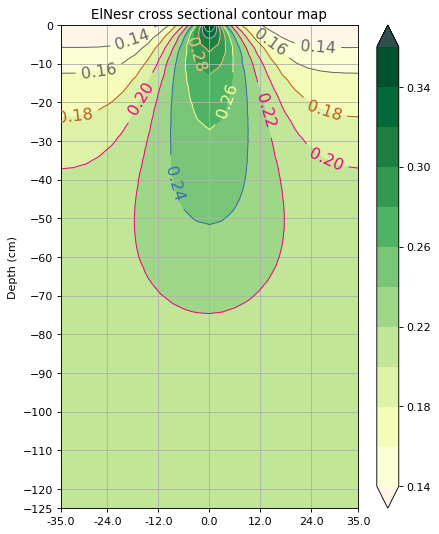

None

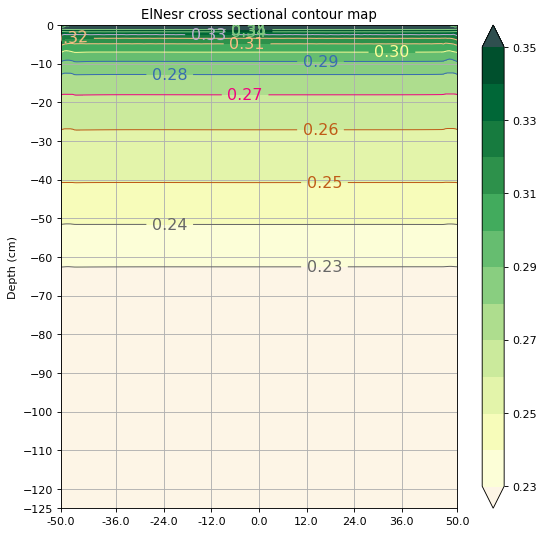

None

,SimulTime_s,L_Unit,T_Unit,Category,MaxIt,TolTh,TolH,InitH/W,lWat,lChem,...,WatBalT720,WatBalT1440,hMean0,hMean15,hMean60,hMean120,hMean180,hMean360,hMean720,hMean1440
Sand Ditch simulation,209.75,1.0,1.0,3.0,10.0,0.001,1.0,1.0,1.0,0.0,...,65.245,124.33,-10.221,-10.229,-10.262,-10.306,-10.344,-11.299,-13.464,-16.12


In [7]:
# testing draw_full_contour function
# data_frame_test = read_hydrus_data(save_to_csv=False)
variable = 0  # Theta

time_step = 180
grid = 0.5  # cm
tol = 10.

section = 'y'
crosses = 50.  #cm0)]
_ = draw_full_contour(
    data_frame,
    variable,
    time_step,
    grid,
    crosses,
    tol,
    section,
    return_arrays=False,
    x_step=12,
    z_step=10,
    mirror_x=True,
    mirror_z=False,
    fig_size=get_fig_shape(data_frame, section))

section = 'x'
crosses = 35.  #cm0)]
_ = draw_full_contour(
    data_frame,
    variable,
    time_step,
    grid,
    crosses,
    tol,
    section,
    return_arrays=False,
    x_step=12,
    z_step=10,
    mirror_x=True,
    mirror_z=False,
    fig_size=get_fig_shape(data_frame, section))

# Get other data from 3D simulation
get_one_line_df(src, simulation_name="Sand Ditch simulation", dims='3d').T

In [8]:
src = '../Datasets/H3D2_SandDitch0011'
df = read_hydrus_data(folder=src, save_to_csv=False, read_velocities=True)
display(df.sample(3), get_full_simulation_info(df))

 For the entire simulation
Time steps : [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions : {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Matrix dims: x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)


 Variables statistics:


,n,x,y,z,Th_T0,Th_T5,Th_T15,Th_T30,Th_T60,Th_T120,...,V3_T240,V1_T500,V2_T500,V3_T500,V1_T720,V2_T720,V3_T720,V1_T1440,V2_T1440,V3_T1440
7019,7019,40.5295,10.75000,16.28960,0.20,0.200000,0.200345,0.235649,0.350014,0.347129,...,-0.000840,0.000015,5.122510e-06,-0.000372,0.000025,3.352860e-06,-0.000211,0.000007,7.764930e-07,-0.000052
6608,6608,33.0295,15.25000,11.78960,0.20,0.200000,0.200000,0.200000,0.200034,0.223006,...,-0.000324,0.000202,5.932090e-06,-0.000189,0.000084,2.583600e-06,-0.000125,-0.000002,4.345180e-07,-0.000059
2175,2175,22.3422,4.61538,4.39625,0.15,0.233115,0.249179,0.255552,0.390000,0.377967,...,-0.000089,-0.000039,3.000400e-07,-0.000054,-0.000028,1.689710e-07,-0.000045,-0.000022,-1.076630e-07,-0.000025


,Min,Mean,Median,Max
Th,0.049132,0.257289,3.117305e-01,0.430000
H,-676.912000,-66.645863,-1.962600e+01,12.429200
V1,-1.660930,-0.021988,-1.864930e-05,0.802749
V2,-0.263769,-0.000331,1.837060e-08,0.265775
V3,-1.086420,-0.002844,-2.684000e-05,0.777201


In [9]:
df_rotated = rotate_back(df, 2.2899, rotation_axis='y')
get_full_simulation_info(df_rotated)

 For the entire simulation
Time steps : [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions : {'x': (0.0, 50.0), 'y': (0.0, 20.0), 'z': (0.0, 21.0)} 
Matrix dims: x_vals(41,), z_vals(43,), X(43, 41), Z(43, 41), M(43, 41)


 Variables statistics:


,Min,Mean,Median,Max
Th,0.049132,0.257289,3.117305e-01,0.430000
H,-676.912000,-66.645863,-1.962600e+01,12.429200
V1,-1.660930,-0.021988,-1.864930e-05,0.802749
V2,-0.263769,-0.000331,1.837060e-08,0.265775
V3,-1.086420,-0.002844,-2.684000e-05,0.777201


"For variable 'Th', the simulation's crosssection at '10.5 cm' of 'y' direction is:"

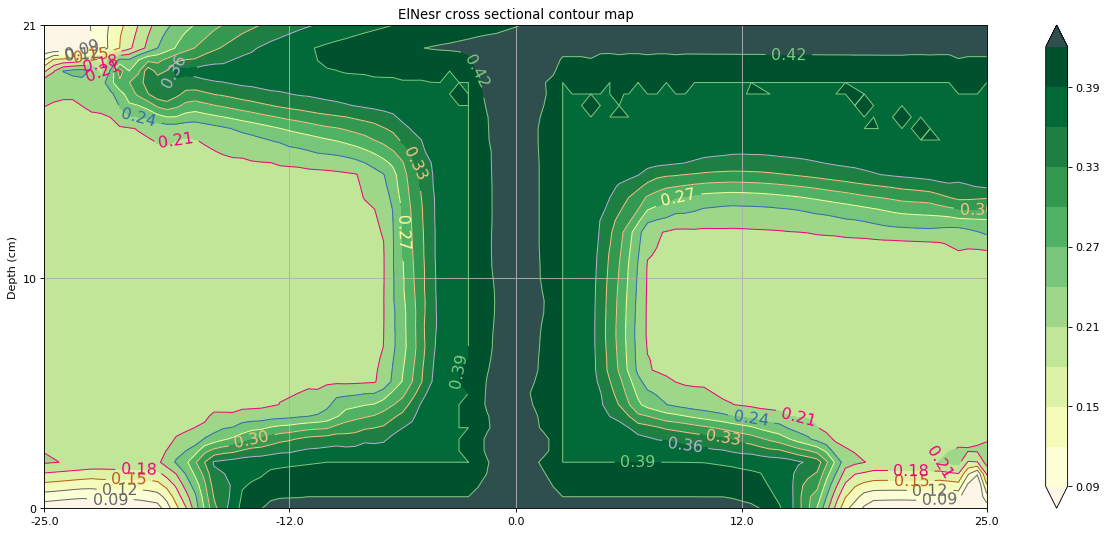

None

"For variable 'H', the simulation's crosssection at '10.5 cm' of 'y' direction is:"

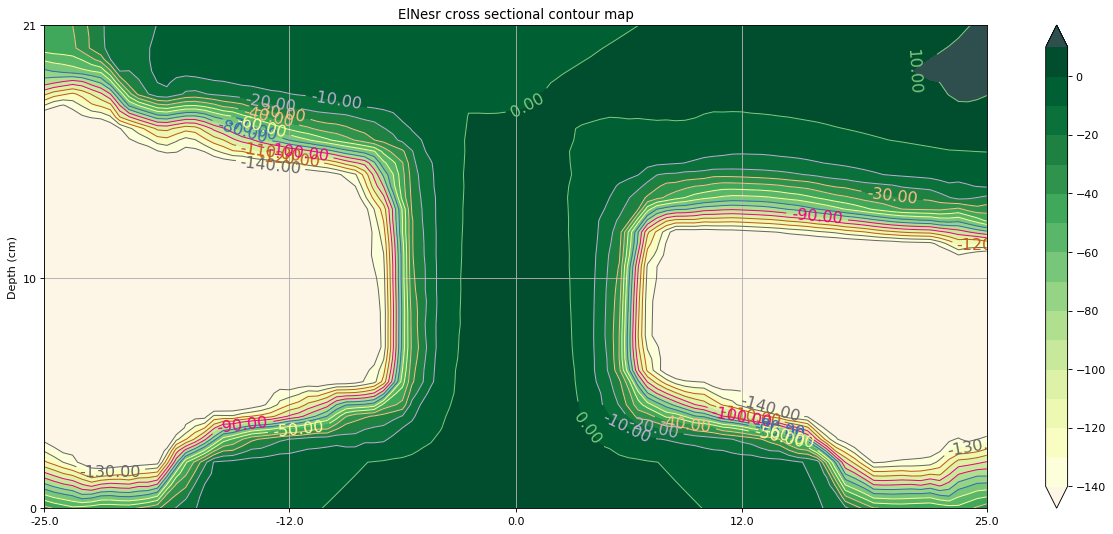

None

"For variable 'Vx', the simulation's crosssection at '10.5 cm' of 'y' direction is:"

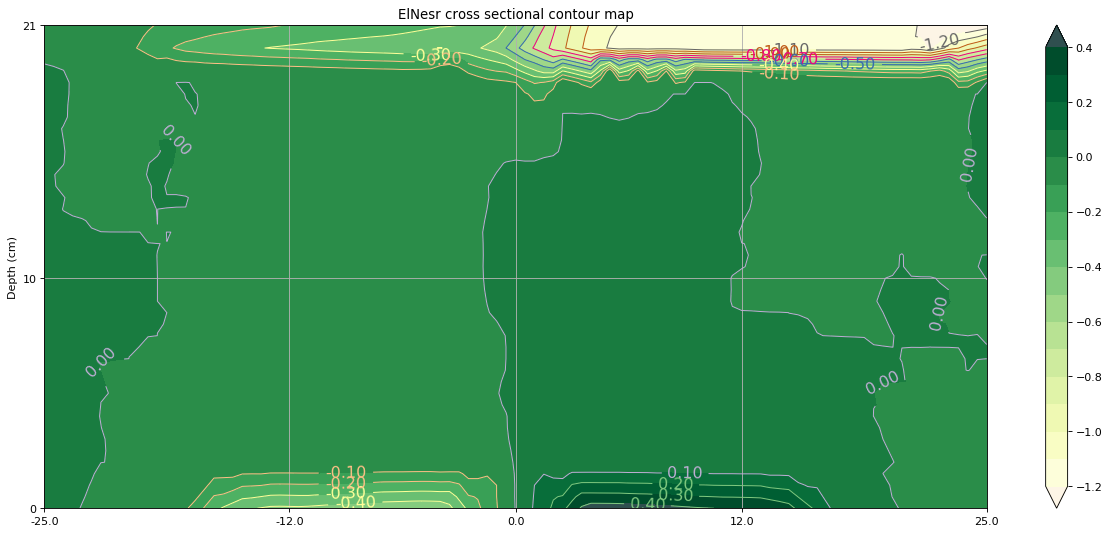

None

"For variable 'Vy', the simulation's crosssection at '10.5 cm' of 'y' direction is:"

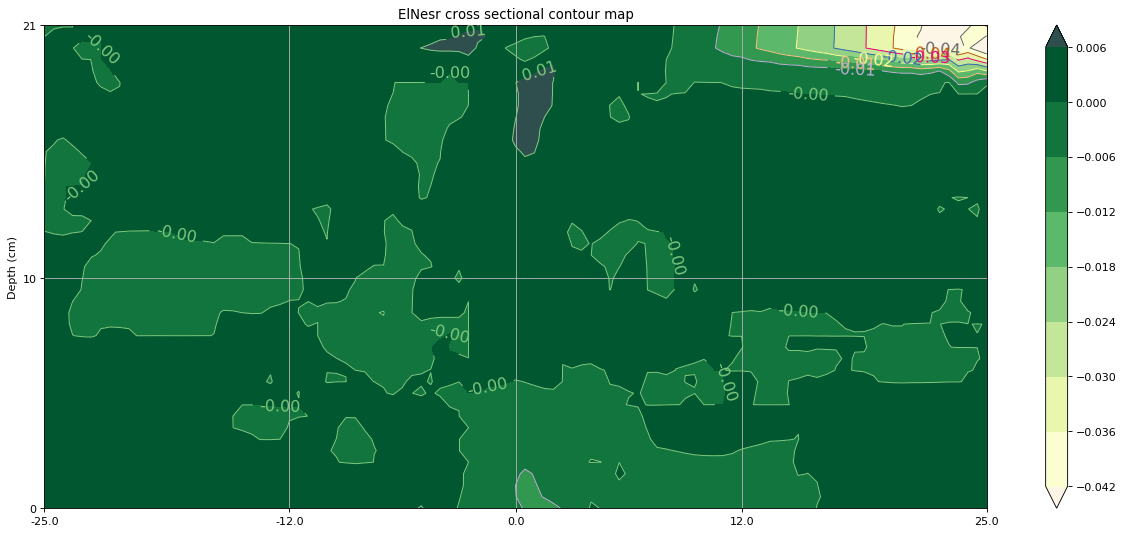

None

"For variable 'Vz', the simulation's crosssection at '10.5 cm' of 'y' direction is:"

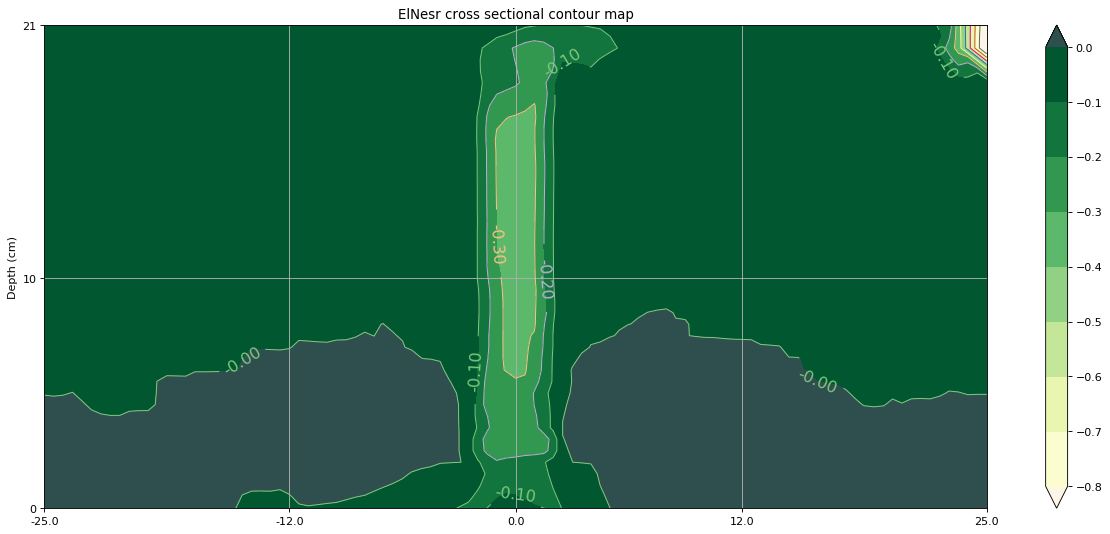

None

"For variable 'Th', the simulation's crosssection at '25.0 cm' of 'x' direction is:"

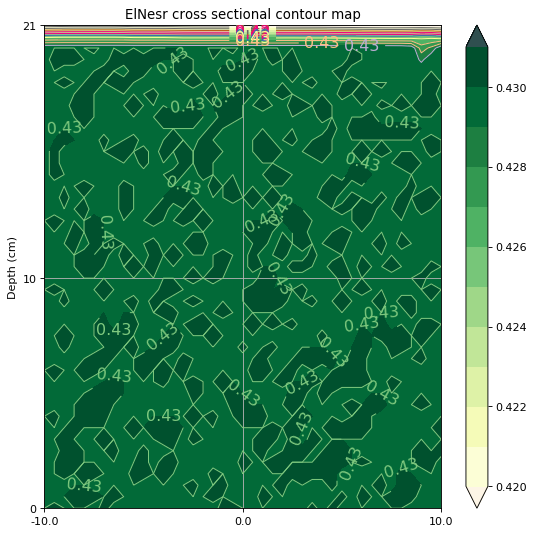

None

"For variable 'H', the simulation's crosssection at '25.0 cm' of 'x' direction is:"

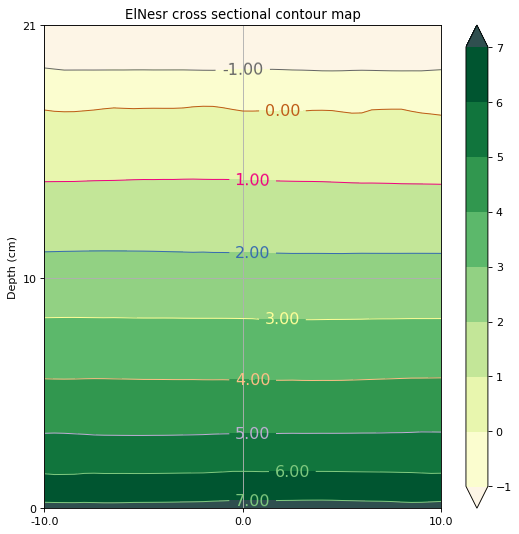

None

"For variable 'Vx', the simulation's crosssection at '25.0 cm' of 'x' direction is:"

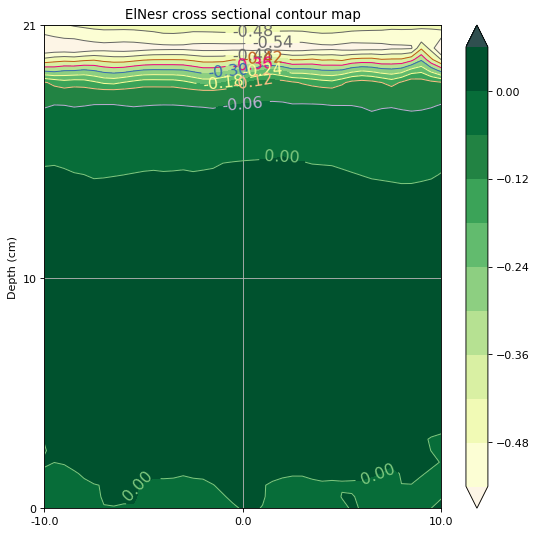

None

"For variable 'Vy', the simulation's crosssection at '25.0 cm' of 'x' direction is:"

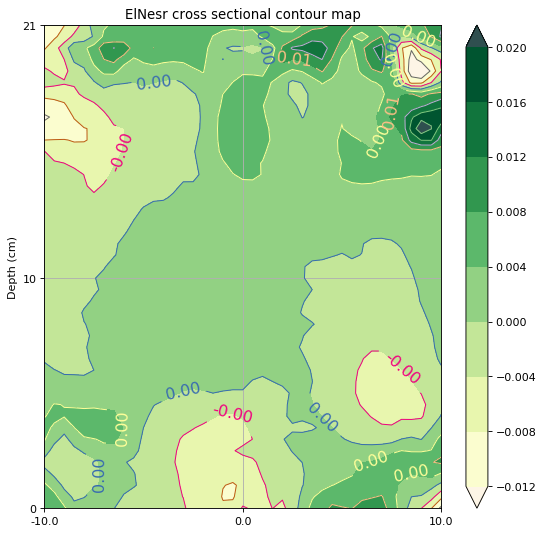

None

"For variable 'Vz', the simulation's crosssection at '25.0 cm' of 'x' direction is:"

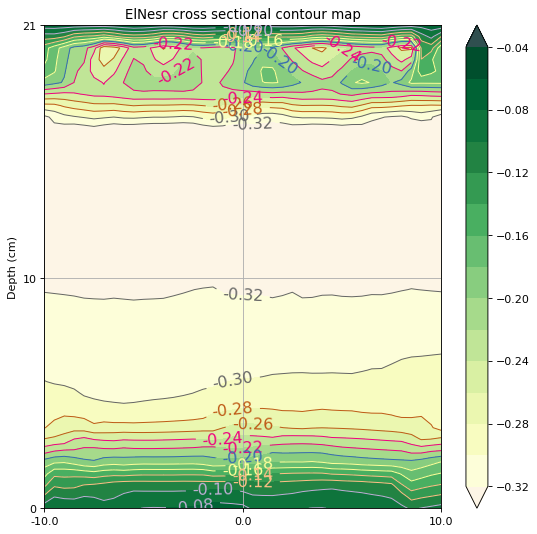

None

"For variable 'Th', the simulation's crosssection at '10.5 cm' of 'z' direction is:"

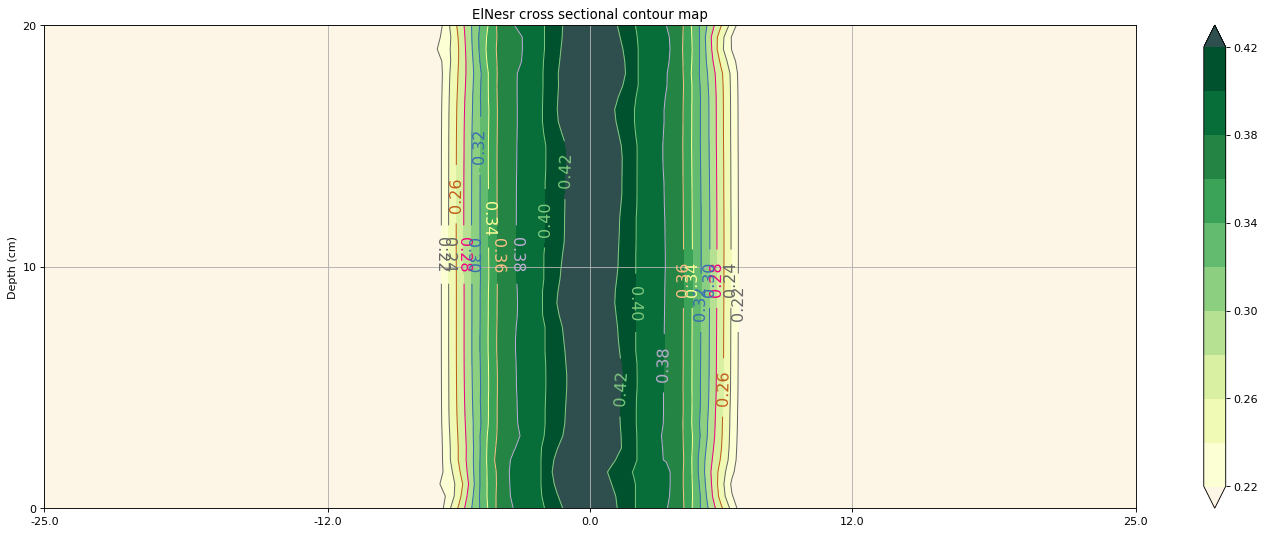

None

"For variable 'H', the simulation's crosssection at '10.5 cm' of 'z' direction is:"

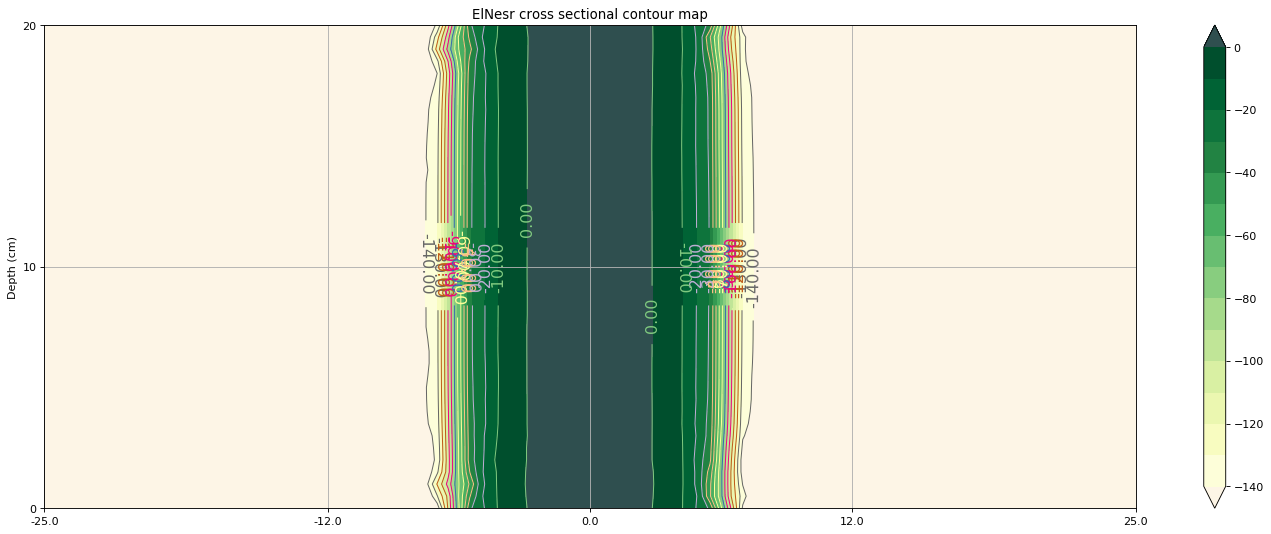

None

"For variable 'Vx', the simulation's crosssection at '10.5 cm' of 'z' direction is:"

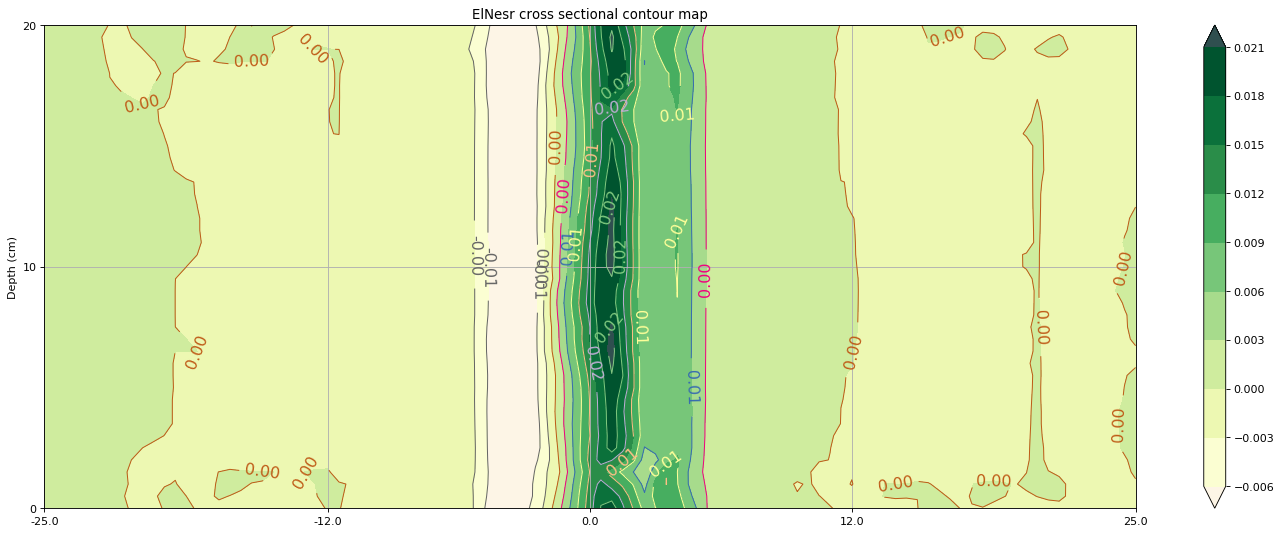

None

"For variable 'Vy', the simulation's crosssection at '10.5 cm' of 'z' direction is:"

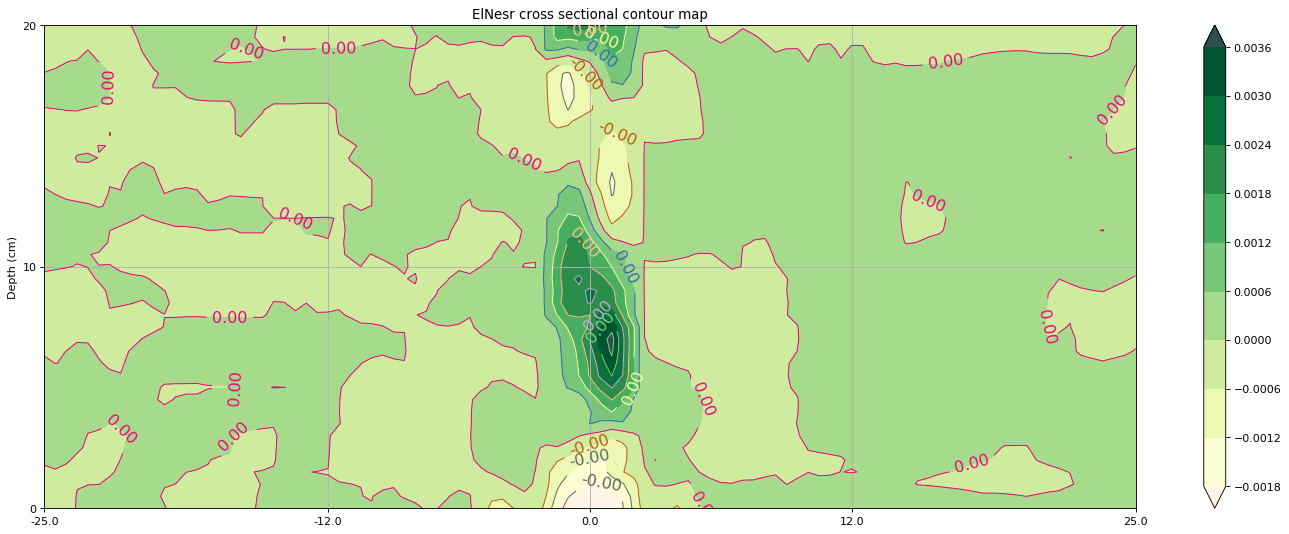

None

"For variable 'Vz', the simulation's crosssection at '10.5 cm' of 'z' direction is:"

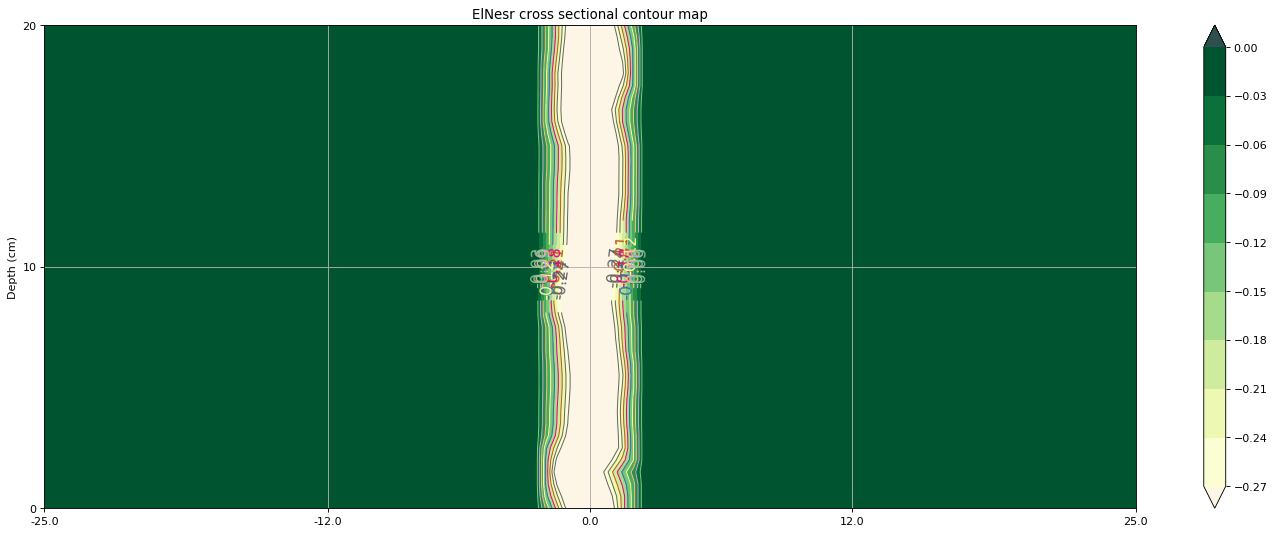

None

In [34]:
time_step = 60
grid = 0.5  # cm
# crosses = 15.  #cm0)]
tol = 10.
v_mask = {0: 'Th', 1: 'H', 2.1: 'V1', 2.2: 'V2', 2.3: 'V3'}
v_mask_cordinates = {0: 'Th', 1: 'H', 2.1: 'Vx', 2.2: 'Vy', 2.3: 'Vz'}
cros_mask = {'x':25.0, 'y':10.5, 'z':10.5}
for section in ['y', 'x', 'z']:
    crosses = cros_mask[section]
    for variable in [0, 1, 2.1, 2.2, 2.3]:
        display(
            f"For variable '{v_mask_cordinates[variable]}', the simulation's "
            f"crosssection at '{crosses} cm' of '{section}' direction is:")
        draw_full_contour(
            df_rotated,
            variable,
            time_step,
            grid,
            crosses,
            tol,
            section,
            return_arrays=False,
            x_step=12,
            z_step=10,
            mirror_x=True,
            mirror_z=False)#,
#             fig_size=get_fig_shape(df, section))

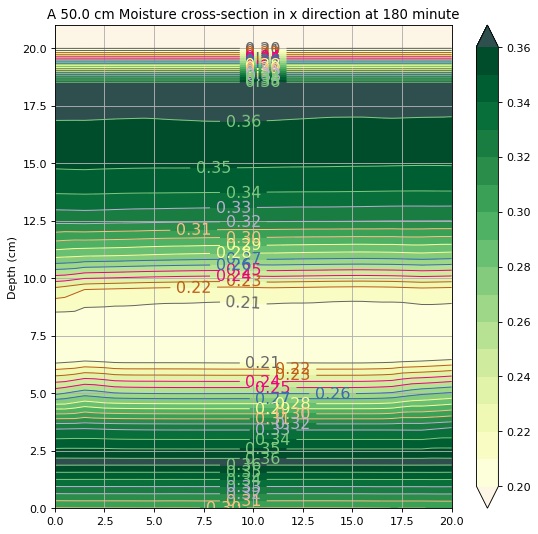

None

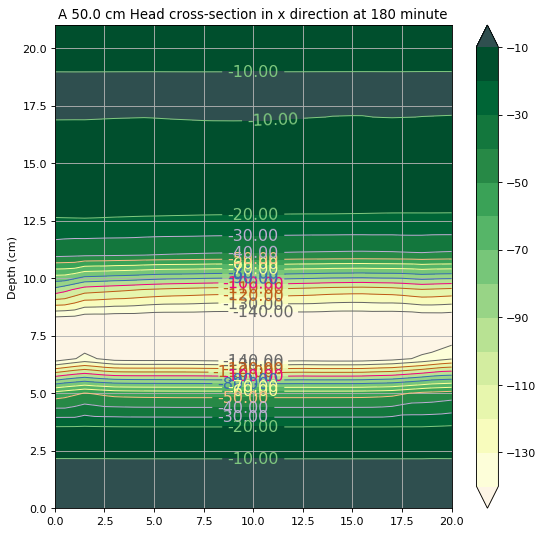

None

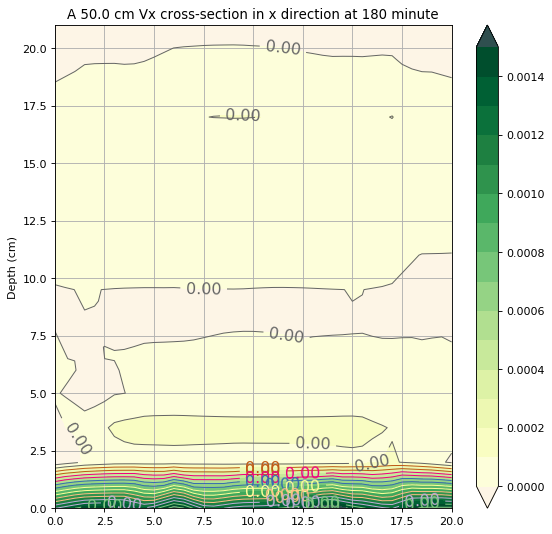

None

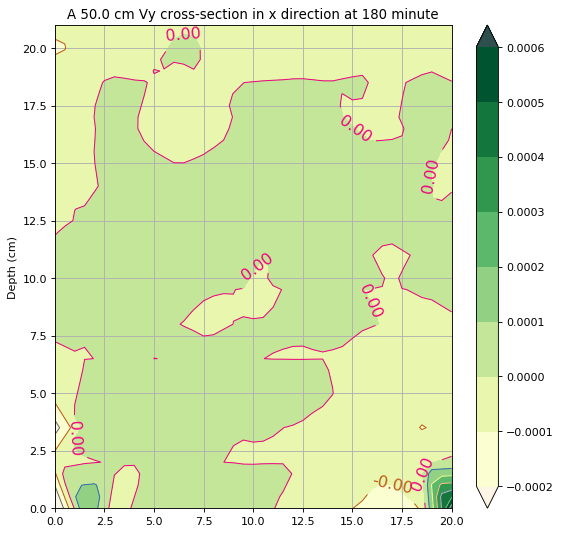

None

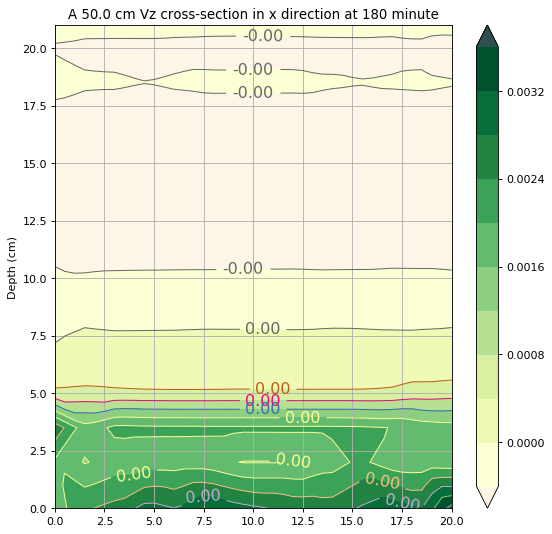

None

In [49]:
section = 'x'
storage = {}
crosses = 50.
time_step = 180
v_mask_cordinates = {0: 'Moisture', 1: 'Head', 2.1: 'Vx', 2.2: 'Vy', 2.3: 'Vz'}
grid=0.5

for var in [0, 1, 2.1, 2.2, 2.3]:
    storage[var] = draw_full_contour(
        df_rotated,
        variable=var,
        time_step=time_step,
        grid=grid,
        crosses=crosses,
        tol=10.,
        section=section,
        levels=None,
        plot_title=f"A {crosses} cm {v_mask_cordinates[var]} cross-section "
        f"in {section} direction at {time_step} minute",
        return_arrays=True,
        x_step=None,
        z_step=None,
        mirror_x=False,
        mirror_z=False,
        is2d=False,
        output_the_contour=True,
        is_axisymmetric=False,
        return_figure_object=False)  #,
#                       fig_size=get_fig_shape(df_rotated, section))

In [50]:
# Moisture values
Y, Z, M, Lm = storage[0]
# Velocity in X direction values
_, _, Vx, Lv = storage[2.1]

In [57]:
Lm, Lv

(array([0.200, 0.210, 0.220, 0.230, 0.240, 0.250, 0.260, 0.270, 0.280,
        0.290, 0.300, 0.310, 0.320, 0.330, 0.340, 0.350, 0.360]),
 array([0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002]))

In [58]:
[x.shape for x in (Y, Z, M, Vx)]

[(43, 41), (43, 41), (43, 41), (43, 41)]

In [62]:
MV = M*Vx
MV.min(), MV.max()

(-2.7941642520000003e-05, 0.00047785626220659007)

In [63]:
MV

array([[0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       ...,
       [-0.000, -0.000, -0.000, ..., -0.000, -0.000, -0.000],
       [-0.000, -0.000, -0.000, ..., -0.000, -0.000, -0.000],
       [-0.000, -0.000, -0.000, ..., -0.000, -0.000, -0.000]])

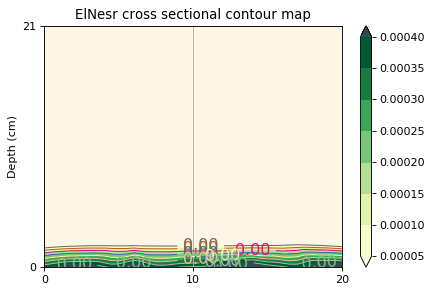

In [69]:
Lmv = get_legend_range(np.nanmin(MV), np.nanmax(MV))
draw_contour(Y, Z, MV, Lmv)

In [86]:
# THis is the full contour
# But the discharge occur only in the bottom 2 cm
# the grid is 0.5 cm * 0.5 cm
# then let's take the last 4+1 points

# section = 'x'  # Commented not to make conflict by the above variables
y_length = get_full_dimensions(df_rotated)['y']
y_grids = Y.shape[0] - 1
# grid = 0.5  # Commented not to make conflict by the above variables

d = 2.0  # the length of the discharge region

ng = int(d / grid) + 1  # Number of grid points
ng

5

In [78]:
# The cropped arrays

Mc, Vc = M[-ng:, :], Vx[-ng:, :]

# The product
MVc = Mc*Vc
MVc

array([[-0.000, -0.000, -0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, -0.000, -0.000, -0.000, -0.000],
       [-0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000,
        -0.000, -0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        -0.000, -0.000, -0.000, -0.000, -0.000, -0.000],
       [-0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000,
        -0.000, -0.000, -0.000, -0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, -0.000, -0.000,
        -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000,
        -0.000, -0.000, -0.000, -0.0

In [94]:
MVc.mean(), np.abs(MVc).mean()

(-4.744140587920975e-06, 9.019487095442114e-06)

In [87]:
# Area of the drain = 2*20 = 40 cm squared
A = d * (y_length[1]-y_length[0])
y_length,A

((0.0, 20.0), 40.0)

In [95]:
# The drainage volume = 
vol = A * np.abs(MVc).mean()
vol

0.0003607794838176846

In [149]:
time_steps = get_available_timesteps(df_rotated)
section = 'x'
crosses = 50.
v_mask_cordinates = {0: 'Moisture', 1: 'Head', 2.1: 'Vx', 2.2: 'Vy', 2.3: 'Vz'}
grid=0.5
time_storage={}
for time_step in time_steps:
    storage = {}
    for var in [0, 2.1]:#[0, 1, 2.1, 2.2, 2.3]:
        storage[var] = draw_full_contour(
            df_rotated,
            variable=var,
            time_step=time_step,
            grid=grid,
            crosses=crosses,
            tol=10.,
            section=section,
            levels=None,
            plot_title=f"A {crosses} cm {v_mask_cordinates[var]} cross-section "
            f"in {section} direction at {time_step} minute",
            return_arrays=True,
            x_step=None,
            z_step=None,
            mirror_x=False,
            mirror_z=False,
            is2d=False,
            output_the_contour=False,
            is_axisymmetric=False,
            return_figure_object=False)

    # Moisture values
    Y, Z, M, Lm = storage[0]
    # Velocity in X direction values
    _, _, Vx, Lv = storage[2.1]

    # section = 'x'  # Commented not to make conflict by the above variables
    y_length = get_full_dimensions(df_rotated)['y']
    y_grids = Y.shape[0] - 1
    # grid = 0.5  # Commented not to make conflict by the above variables

    d = 2.0  # the length of the discharge region
    region_end = 20
    region_start = region_end - d
    
    

    ng = int(d / grid) + 1  # Number of grid points

    # The cropped arrays
    Mc, Vc = M[-ng:, :], Vx[-ng:, :]

    # The product
    MVc = Mc*Vc
    
    print(d, region_end, region_start, ng)
    
    # Area of the drain = 2*20 = 40 cm squared
    A = d * (y_length[1]-y_length[0])

    # The drainage volume = 
    vol = A * np.abs(MVc).mean()
    
    time_storage[time_step] = vol

time_storage

{0: 0.0030788018684812847,
 5: 13.755568031586748,
 15: 13.805302592217695,
 30: 13.8466374828078,
 60: 13.869340571563677,
 120: 0.0020477978163028826,
 180: 0.0003607794838176846,
 240: 0.00021566747518063806,
 500: 0.00012076481775008703,
 720: 7.272059683076379e-05,
 1440: 1.6658353838414046e-05}

## A function to calculate volumes flow in all times AnyWhere

In [115]:
d = 2.0  # the length of the discharge region
region_end = 20
region_start = region_end - d
ng = int(d / grid) + 1  # Number of grid points

display(d, region_start, region_end, ng, 
        M[-ng:, 1:8],
        int(region_start / grid) + 2,
        int(region_end / grid) + 3,
        M[int(region_start / grid)+2 :int(region_end / grid) + 3, 1:8],
       M[:,1:8])

2.0

18.0

20

5

array([[0.240, 0.240, 0.240, 0.240, 0.240, 0.240, 0.240],
       [0.165, 0.165, 0.165, 0.165, 0.165, 0.165, 0.165],
       [0.090, 0.090, 0.090, 0.090, 0.090, 0.090, 0.090],
       [0.088, 0.088, 0.088, 0.088, 0.088, 0.088, 0.088],
       [0.087, 0.087, 0.087, 0.087, 0.087, 0.087, 0.087]])

38

43

array([[0.240, 0.240, 0.240, 0.240, 0.240, 0.240, 0.240],
       [0.165, 0.165, 0.165, 0.165, 0.165, 0.165, 0.165],
       [0.090, 0.090, 0.090, 0.090, 0.090, 0.090, 0.090],
       [0.088, 0.088, 0.088, 0.088, 0.088, 0.088, 0.088],
       [0.087, 0.087, 0.087, 0.087, 0.087, 0.087, 0.087]])

array([[0.228, 0.228, 0.228, 0.228, 0.228, 0.228, 0.228],
       [0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259],
       [0.291, 0.291, 0.291, 0.291, 0.291, 0.291, 0.291],
       [0.323, 0.323, 0.323, 0.323, 0.323, 0.322, 0.322],
       [0.354, 0.354, 0.354, 0.354, 0.354, 0.354, 0.354],
       [0.352, 0.352, 0.352, 0.352, 0.352, 0.352, 0.352],
       [0.350, 0.350, 0.350, 0.350, 0.350, 0.350, 0.350],
       [0.349, 0.349, 0.349, 0.349, 0.349, 0.349, 0.349],
       [0.347, 0.347, 0.347, 0.347, 0.347, 0.347, 0.347],
       [0.345, 0.345, 0.345, 0.345, 0.345, 0.345, 0.345],
       [0.344, 0.344, 0.344, 0.344, 0.344, 0.344, 0.344],
       [0.342, 0.342, 0.342, 0.342, 0.342, 0.342, 0.342],
       [0.340, 0.340, 0.340, 0.340, 0.340, 0.340, 0.340],
       [0.339, 0.339, 0.339, 0.339, 0.339, 0.339, 0.339],
       [0.337, 0.337, 0.337, 0.337, 0.337, 0.337, 0.337],
       [0.336, 0.336, 0.336, 0.336, 0.336, 0.336, 0.336],
       [0.335, 0.335, 0.335, 0.335, 0.335, 0.335, 0.335],
       [0.333,

In [118]:
sample_array = np.random.random(54).reshape((9, 6))
sample_array

array([[0.050, 0.334, 0.930, 0.980, 0.555, 0.232],
       [0.442, 0.415, 0.094, 0.168, 0.720, 0.861],
       [0.649, 0.963, 0.552, 0.244, 0.695, 0.234],
       [0.272, 0.918, 0.067, 0.573, 0.100, 0.840],
       [0.475, 0.730, 0.830, 0.108, 0.368, 0.008],
       [0.381, 0.346, 0.039, 0.996, 0.204, 0.710],
       [0.872, 0.126, 0.354, 0.089, 0.661, 0.034],
       [0.055, 0.299, 0.998, 0.429, 0.537, 0.277],
       [0.720, 0.972, 0.521, 0.938, 0.972, 0.618]])

In [121]:
sample_array[0:3,:], sample_array[6:9,:]

(array([[0.050, 0.334, 0.930, 0.980, 0.555, 0.232],
        [0.442, 0.415, 0.094, 0.168, 0.720, 0.861],
        [0.649, 0.963, 0.552, 0.244, 0.695, 0.234]]),
 array([[0.872, 0.126, 0.354, 0.089, 0.661, 0.034],
        [0.055, 0.299, 0.998, 0.429, 0.537, 0.277],
        [0.720, 0.972, 0.521, 0.938, 0.972, 0.618]]))

for this `sample_array` it is a **4.0cm** height and **2.5cm** width with **0.5cm** grid

In [131]:
# for this sample_array it is a 4cm height and 2.5cm width with 0.5cm grid

d = 1.0  # the length of the discharge region

for rgn_e in [1.0, 2.5, 4.0]:  # region_end
    rgn_s = rgn_e - d  # region_start
    # ng = int(d / grid) + 1  # Number of grid points

    grd_s, grd_e = int(rgn_s / grid), int(rgn_e / grid + 1)

    print(d, rgn_s, rgn_e, ng, grd_s, grd_e)
    display(sample_array[grd_s:grd_e, :], )

1.0 0.0 1.0 3 0 3


array([[0.050, 0.334, 0.930, 0.980, 0.555, 0.232],
       [0.442, 0.415, 0.094, 0.168, 0.720, 0.861],
       [0.649, 0.963, 0.552, 0.244, 0.695, 0.234]])

1.0 1.5 2.5 3 3 6


array([[0.272, 0.918, 0.067, 0.573, 0.100, 0.840],
       [0.475, 0.730, 0.830, 0.108, 0.368, 0.008],
       [0.381, 0.346, 0.039, 0.996, 0.204, 0.710]])

1.0 3.0 4.0 3 6 9


array([[0.872, 0.126, 0.354, 0.089, 0.661, 0.034],
       [0.055, 0.299, 0.998, 0.429, 0.537, 0.277],
       [0.720, 0.972, 0.521, 0.938, 0.972, 0.618]])

In [148]:
def get_window_time_volumes(
        df,
        crosses,
        region_length,
        region_location,
        location_is_start=False,  #the region_location =  region_end
        section='x',
        grid=0.5,
        absolute_velocities=True
):
    time_steps = get_available_timesteps(df)
    section = section
    # crosses = 50.
    v_mask_cordinates = {
        0: 'Moisture',
        1: 'Head',
        2.1: 'Vx',
        2.2: 'Vy',
        2.3: 'Vz'
    }
    plot_title=''
#     plot_title=f"A {crosses} cm {v_mask_cordinates[var]} cross-section "\
#                 f"in {section} direction at {time_step} minute"
    grid = grid
    time_storage = {}
    velocity={'x': 2.1, 'y': 2.2, 'z': 2.3}[section.lower()]
    variables = [0, velocity]
    for time_step in time_steps:
        storage = {}
        for var in variables:  #[0, 1, 2.1, 2.2, 2.3]:
            storage[var] = draw_full_contour(
                df,
                variable=var,
                time_step=time_step,
                grid=grid,
                crosses=crosses,
                tol=10.,
                section=section,
                levels=None,
                plot_title=plot_title,
                return_arrays=True,
                x_step=None,
                z_step=None,
                mirror_x=False,
                mirror_z=False,
                is2d=False,
                output_the_contour=False,
                is_axisymmetric=False,
                return_figure_object=False)

        # Moisture values
        Y, Z, M, Lm = storage[0]
        # Velocity in X direction values
        _, _, Vx, Lv = storage[velocity]  # to get storage[2.1 if 'x']

        # section = 'x'  # Commented not to make conflict by the above variables
        y_length = get_full_dimensions(df)[{
            'x': 'y',
            'y': 'x',
            'z': 'y'
        }[section.lower()]]  # to get_full_dimensions(df)['y'] if 'x'

        y_grids = Y.shape[0] - 1

        if location_is_start:
            region_start = region_location
            region_end = region_start + region_length
        else:
            region_end = region_location
            region_start = region_end - region_length


#         ng = int(dregion_length / grid) + 1  # Number of grid points
        grd_s, grd_e = int(region_start / grid), int(region_end / grid + 1)

        # The cropped arrays
        Mc, Vc = M[grd_s:grd_e, :], Vx[grd_s:grd_e, :]

        # The product
        MVc = Mc * Vc

        # Area of the drain = 2*20 = 40 cm squared
        A = region_length * (y_length[1] - y_length[0])

        # The drainage volume =
        if absolute_velocities:
            vol = A * np.nanmean(np.abs(MVc))
        else:
            vol = A * p.nanmean(MVc)

        time_storage[time_step] = vol
        
    return time_storage

In [150]:
# Testing
get_window_time_volumes(
    df_rotated,
    50,
    2,
    region_location=21,
    location_is_start=False,  #the region_location =  region_end
    section='x',
    grid=0.5,
    absolute_velocities=True)

{0: 0.0030788018684812847,
 5: 13.755568031586748,
 15: 13.805302592217695,
 30: 13.8466374828078,
 60: 13.869340571563677,
 120: 0.0020477978163028826,
 180: 0.0003607794838176846,
 240: 0.00021566747518063806,
 500: 0.00012076481775008703,
 720: 7.272059683076379e-05,
 1440: 1.6658353838414046e-05}